In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 128
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 10000

In [4]:
def load_data():
    (x_train, _), (_, _) = mnist.load_data()
    x_train = x_train / 127.5 - 1.
    x_train = np.expand_dims(x_train, axis = 3)
    return x_train

In [5]:
x_train = load_data()
x_train.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

In [6]:
def build_generator(latent_dimension, image_shape, optimizer):
    generator = Sequential([
        Dense(256, input_dim = latent_dimension),
        LeakyReLU(0.2),
        Dense(512),
        LeakyReLU(0.2),
        Dense(1024),
        LeakyReLU(0.2),
        Dense(np.prod(image_shape), activation = 'tanh')
    ], name = 'Generator')
    generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    return generator

In [7]:
def build_discriminator(image_shape, optimizer):
    discriminator = Sequential([
        Dense(1024, input_dim = np.prod(image_shape)),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(512),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(256),
        LeakyReLU(0.2),
        Dense(1, activation = 'sigmoid')
    ], name = 'Discriminator')
    discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    return discriminator

In [8]:
def build_gan(generator, discriminator, latent_dimension, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape = (latent_dimension, ))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output, name = 'GAN')
    gan.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return gan

In [9]:
optimizer = Adam(0.0002, 0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
generator = build_generator(LATENT_DIMENSION, IMAGE_SHAPE, optimizer)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               803600    
Total para

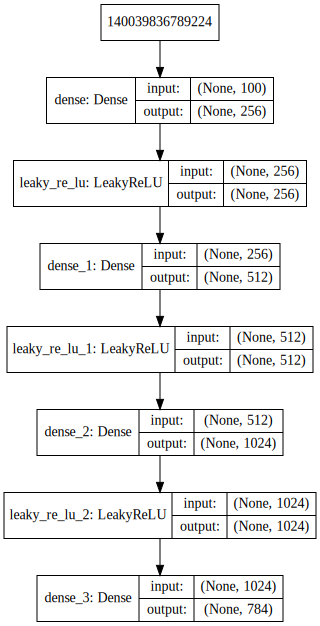

In [11]:
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [12]:
discriminator = build_discriminator(IMAGE_SHAPE, optimizer)
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
___________________________

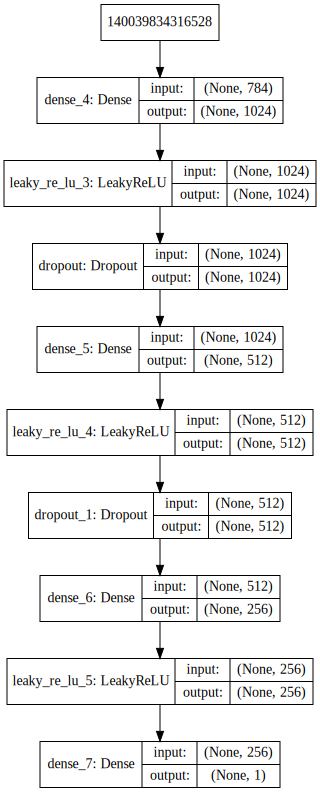

In [13]:
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [14]:
gan = build_gan(generator, discriminator, LATENT_DIMENSION, optimizer)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Generator (Sequential)       (None, 784)               1486352   
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


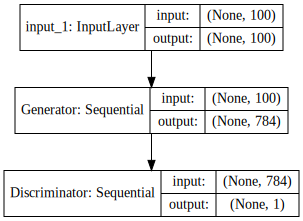

In [15]:
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [16]:
def plot_images(nrows, ncols, figsize, generator):
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    noise = np.random.normal(0, 1, (nrows * ncols, LATENT_DIMENSION))
    generated_images = generator.predict(noise).reshape(nrows * ncols, IMAGE_WIDTH, IMAGE_HEIGHT)
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap = 'gray')
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


 10%|▉         | 998/10000 [00:22<02:36, 57.36it/s]

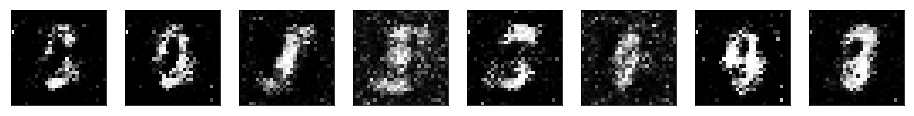

 20%|█▉        | 1994/10000 [00:39<02:10, 61.42it/s]

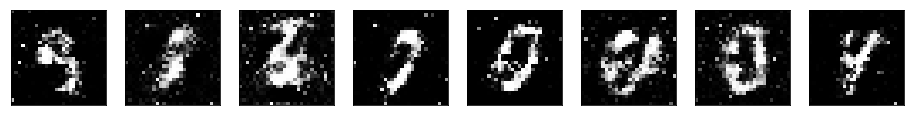

 30%|██▉       | 2996/10000 [00:55<01:53, 61.93it/s]

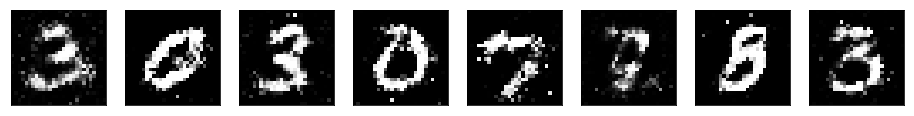

 40%|███▉      | 3999/10000 [01:12<01:38, 60.91it/s]

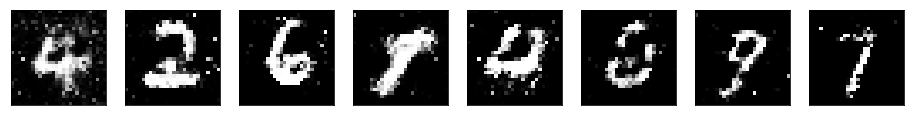

 50%|████▉     | 4998/10000 [01:29<01:20, 62.31it/s]

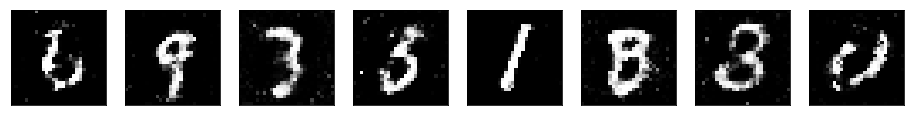

 60%|█████▉    | 5996/10000 [01:46<01:05, 60.76it/s]

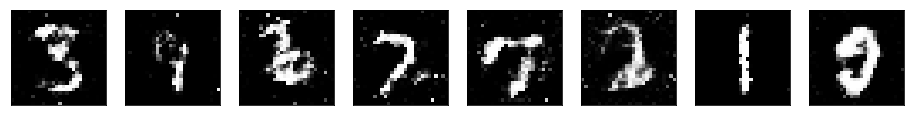

 70%|██████▉   | 6993/10000 [02:03<00:47, 62.67it/s]

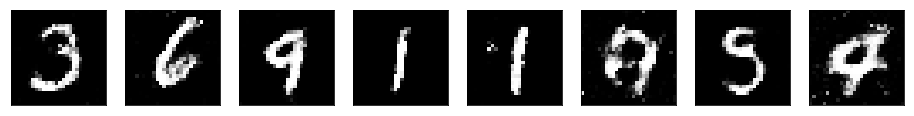

 80%|███████▉  | 7997/10000 [02:19<00:32, 61.12it/s]

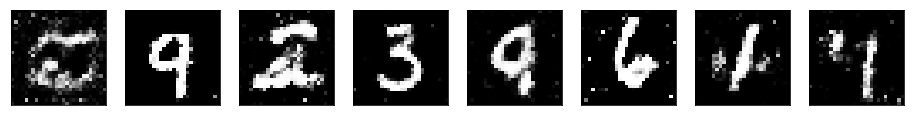

 90%|████████▉ | 8994/10000 [02:36<00:16, 62.27it/s]

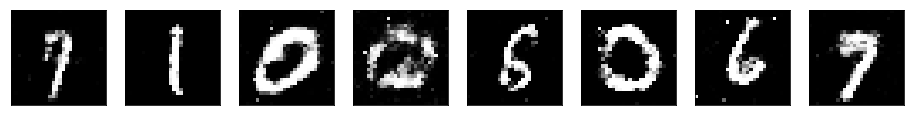

100%|█████████▉| 9995/10000 [02:53<00:00, 62.10it/s]

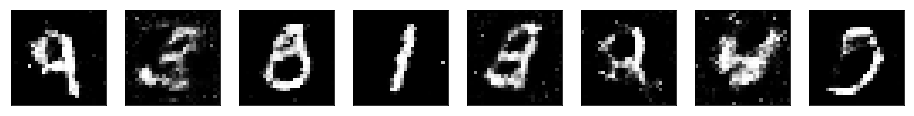

100%|██████████| 10000/10000 [02:53<00:00, 57.55it/s]


In [17]:
generator_loss_history, discriminator_loss_history = [], []

for epoch in tqdm(range(1, EPOCHS + 1)):
    
    # Select a random batch of images from training data
    index = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
    batch_images = x_train[index].reshape(BATCH_SIZE, 784)
    
    # Adversarial Noise
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIMENSION))
    
    # Generate fake images
    generated_images = generator.predict(noise)
    
    # Construct batches of real and fake data
    x = np.concatenate([batch_images, generated_images])
    
    # Labels for training the discriminator
    y_discriminator = np.zeros(2 * BATCH_SIZE)
    y_discriminator[: BATCH_SIZE] = 0.9
    
    # train the discrimator to distinguish between fake data and real data
    discriminator.trainable = True
    discriminator_loss = discriminator.train_on_batch(x, y_discriminator)
    discriminator_loss_history.append(discriminator_loss)
    discriminator.trainable = False
    
    # Training the GAN
    generator_loss = gan.train_on_batch(noise, np.ones(BATCH_SIZE))
    generator_loss_history.append(generator_loss)
    
    if epoch % 1000 == 0:
        plot_images(1, 8, (16, 4), generator)

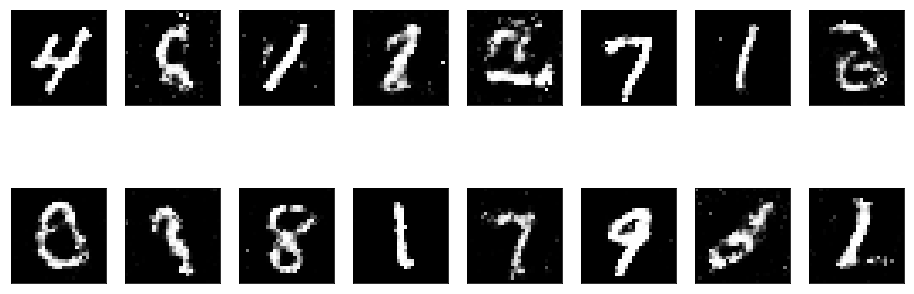

In [18]:
plot_images(2, 8, (16, 6), generator)

In [19]:
generator.save('./generator.h5')